In [1]:
import csv
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
FILE_PATH_PUBLICATIONS = 'publications.csv'
FILE_PATH_PEOPLE = 'people.csv'
FILE_PATH_PROJECTS = 'projects.csv'

### Semicolon to Comma Delimiter

In [27]:
# Read the semicolon-separated CSV file
filename = FILE_PATH_PROJECTS # Change to your file name
df = pd.read_csv(filename, sep=';')

# Save it as a comma-separated CSV file
df.to_csv(FILE_PATH_PROJECTS, index=False, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 13, saw 2


### Comma to Semicolon Delimiter

In [ ]:
# Read the comma-separated CSV file
filename = FILE_PATH_PUBLICATIONS  # Change to your file name
df = pd.read_csv(filename, quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

# Save it as a semicolon-separated CSV file
df.to_csv(FILE_PATH_PUBLICATIONS, index=False, sep=';', quoting=csv.QUOTE_NONE, escapechar='\\')

## Adding New Publications

Adding publications can be done by calling the update_publications(doi, main_author) function. The DOI should be in the format 10.1007/s11616-005-0142-4 (without https etc.). The main_author only has to be specified if for some reason it is not the first named author for our purposes. Otherwise it will automatically be determined.

In [28]:
def update_publications(doi, main_author=None):
    crossref_url = f'https://api.crossref.org/works/{doi}'
    datacite_url = f'https://api.datacite.org/works/{doi}'
    
    response = requests.get(crossref_url)
    source = 'crossref'
    
    if response.status_code != 200:
        print(f"CrossRef does not have metadata for {doi}. Trying DataCite.")
        response = requests.get(datacite_url)
        source = 'datacite'
        
        if response.status_code != 200:
            raise ValueError(f"Failed to get metadata for {doi}.")
    
    if 'application/json' not in response.headers.get('Content-Type', ''):
        raise ValueError(f"Unexpected response format: {response.headers.get('Content-Type')}. JSON expected.")
    
    try:
        data = response.json()
    except json.JSONDecodeError:
        raise ValueError(f"Failed to decode JSON. Response content: {response.text}")

    try:
        if source == 'crossref':
            title = data['message']['title'][0]
            authors = data['message']['author']
            year = data['message']['created']['date-parts'][0][0]
            outlet = data['message']['container-title'][0]
        elif source == 'datacite':
            title = data['data']['attributes']['title']
            authors = data['data']['attributes']['author']
            year = data['data']['attributes']['published']
            outlet = data['data']['attributes']['container-title']
            
        # Process authors to handle 'literal' and 'name' formats.
        processed_authors = []
        for author in authors:
            if 'given' in author and 'family' in author:
                processed_authors.append({
                    'given': author['given'],
                    'family': author['family']
                })
            elif 'literal' in author:
                parts = [part.strip() for part in author['literal'].split(',', 1)]
                family = parts[0]
                given = parts[1] if len(parts) > 1 else ''
                processed_authors.append({
                    'given': given,
                    'family': family
                })
            elif 'name' in author:  # Handling organizational authors.
                processed_authors.append({
                    'given': '',
                    'family': author['name']
                })
            else:
                raise ValueError(f"Unexpected author format: {author}")
        authors = processed_authors
    
    except KeyError as e:
        raise ValueError(f"Failed to extract data. Missing key: {e}")
    
    if main_author is not None:
        author = next((a for a in authors if f"{a['given']} {a['family']}" == main_author), None)
        if author is None:
            raise ValueError(f"Main author '{main_author}' not found in the publication's author list.")
    else:
        author = authors[0]
    
    # Composing author names, excluding organizational authors.
    author_names = ", ".join([f"{a['given']} {a['family']}".strip() for a in authors if a['given'].strip()])
    main_author_name = f"{author['given']} {author['family']}"

    highest_id = 0
    with open(FILE_PATH_PUBLICATIONS, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row:
                try:
                    id = int(row[0])
                    highest_id = max(highest_id, id)
                    if doi == row[1]:
                        return
                except ValueError:
                    pass

    with open(FILE_PATH_PUBLICATIONS, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([highest_id + 1, doi, title, main_author_name, author_names, year, outlet])

In [54]:
update_publications('10.1016/j.ijresmar.2021.09.008')

In [45]:
doi = "10.17705/1jais.00732"  # Replace with the DOI you are interested in
url = f"https://api.datacite.org/works/{doi}"

response = requests.get(url)

if response.status_code == 200:
    json_response = response.json()
    print(json.dumps(json_response, indent=4))  # Pretty print the JSON
else:
    print(f"Failed to retrieve data for {doi}. Status code: {response.status_code}")

Failed to retrieve data for 10.17705/1jais.00732. Status code: 404


## Adding People

Adding people can be done by calling the update_people(name, role, university, institute, gender, status) function.

In [5]:
def update_people(name, role, university, institute, gender, status):
    # Check if the person is already in the CSV file
    with open(FILE_PATH_PEOPLE, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['Name'] == name:
                print(f'{name} is already in the file.')
                return
        
    # Add the person's information to the CSV file
    with open(FILE_PATH_PEOPLE, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Add a new row to the CSV file
        writer.writerow([name, role, university, institute, gender, status])
        
        print(f'{name} has been added to the file.')

## Normalize Text

It makes sense to run this after adding new Publications or names to handle Umlauts and second names.

In [55]:
# Normalize Names

# Load the CSV file into a DataFrame
df_pub = pd.read_csv(FILE_PATH_PUBLICATIONS, delimiter=",")
df_peop = pd.read_csv(FILE_PATH_PEOPLE, delimiter=",")

# Define the function to replace umlauts
def replace_irregularities(s):
    s = s.replace('ä', 'ae')
    s = s.replace('ö', 'oe')
    s = s.replace('ü', 'ue')
    s = s.replace('Ä', 'Ae')
    s = s.replace('Ö', 'Oe')
    s = s.replace('Ü', 'Ue')
    s = s.replace('ß', 'ss')
    s = s.replace('Michael T. Knierim', 'Michael Knierim')
    s = s.replace('Pascal Oliver Hessler', 'Pascal Hessler')
    s = s.replace('Pascal Oliver Heßler', 'Pascal Hessler')
    s = s.replace('Michael Thomas Knierim', 'Michael Knierim')
    s = s.replace('Lorenzo Del Puppo', 'Lorenzo del Puppo')
    s = s.replace('Lorenzo Puppo', 'Lorenzo del Puppo')
    return s

# Apply the function to Dataframes
df_pub['main_author_name'] = df_pub['main_author_name'].apply(replace_irregularities)
df_pub['author_names'] = df_pub['author_names'].apply(replace_irregularities)

df_peop['team'] = df_peop['team'].apply(replace_irregularities)
df_peop['last_name'] = df_peop['last_name'].apply(replace_irregularities)
df_peop['name'] = df_peop['name'].apply(replace_irregularities)


# Save the updated DataFrame back to a CSV file
df_pub.to_csv(FILE_PATH_PUBLICATIONS, index=False, sep=',')
df_peop.to_csv(FILE_PATH_PEOPLE, index=False, sep=',')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 41, saw 2


## Update Publication Metrics

This is to update the counts of publications per member with the update_publications_count() function. The update_publication_details function calculates the multi-KD2 Variable and the Cross-Research-Group Variable.

They are is split from the update_publications and update_people function and has to be done manually so that you can still add publications or people by hand in excel if you want so.

In [60]:
def update_publications_count():
    # Load the data
    people_df = pd.read_csv('people.csv', delimiter=',')
    publications_df = pd.read_csv('publications.csv', delimiter=',')

    # Count the number of publications for each person
    publications_count = publications_df['main_author_name'].value_counts()

    # Update the people dataframe with the publications count
    people_df['publications'] = people_df['name'].apply(lambda x: publications_count.get(x, 0))

    # Count the number of occurrences of each last name in the publications dataframe
    author_names = publications_df['author_names'].str.split(',')
    author_names = author_names.explode()
    author_last_names = author_names.str.split().str[-1]
    last_name_counts = author_last_names.value_counts()

    # Update the people dataframe with the last name counts
    people_df['features'] = people_df['last_name'].apply(lambda x: last_name_counts.get(x, 0))

    # Save the updated dataframe to file
    people_df.to_csv('people.csv', index=False, sep=',')

In [61]:
def update_publications_details():
    ### Update Multi-KD2-Column
    
    # Load the data
    publications_df = pd.read_csv(FILE_PATH_PUBLICATIONS, delimiter=',')
    people_df = pd.read_csv(FILE_PATH_PEOPLE, delimiter=',')

    # Create a dictionary of last names and counts
    last_name_counts = dict(people_df['last_name'].value_counts())

    # Create a dictionary of author names and counts
    author_name_counts = dict(publications_df['author_names'].value_counts())

    # Count the number of times a person's last name appears in the author names column
    publications_df['multi_kd2'] = publications_df['author_names'].str.split(',').apply(lambda x: sum([1 for name in x if name.split()[-1] in last_name_counts]))

    # Save the updated data
    publications_df.to_csv(FILE_PATH_PUBLICATIONS, sep=',', index=False)
        
    ### Update Cross-Team Column
    
    # Load the data
    pub_df = pd.read_csv(FILE_PATH_PUBLICATIONS, delimiter=',')
    people_df = pd.read_csv(FILE_PATH_PEOPLE, delimiter=',')

    # Create a dictionary to store the teams for each publication
    pub_to_teams = {pub_id: set() for pub_id in pub_df['id'].unique()}

    for _, person in people_df.iterrows():
        last_name = person['last_name']
        teams = person['team'].split(',')
        matching_pubs = pub_df[pub_df['author_names'].str.contains(last_name, na=False)]
        for pub_id in matching_pubs['id']:
            pub_to_teams[pub_id].update(teams)

    for key in pub_to_teams:
        pub_to_teams[key] = set(pub_to_teams[key])

    pub_df['cross_team_kd2'] = pub_df['id'].map(lambda x: len(pub_to_teams[x])).fillna(0).astype(int)
    
    # Save the updated data
    pub_df.to_csv(FILE_PATH_PUBLICATIONS, sep=',', index=False)

In [62]:
update_publications_count()
update_publications_details()

## Visualization

In [87]:
# Publication Types
import matplotlib.pyplot as plt

# Set a style
plt.style.use('seaborn')

# Set custom rcParams for consistent styling
plt.rcParams['axes.grid.which'] = 'both'  # Apply grid to both major and minor ticks
plt.rcParams['axes.grid.axis'] = 'y'  # Apply grid only to y-axis
plt.rcParams['grid.color'] = 'white'  # Set grid color

# Adjust default text sizes
plt.rcParams['font.size'] = 14         # General font size
plt.rcParams['axes.labelsize'] = 16    # Axes labels
plt.rcParams['axes.titlesize'] = 18    # Title
plt.rcParams['xtick.labelsize'] = 14   # x-axis tick labels
plt.rcParams['ytick.labelsize'] = 14   # y-axis tick labels
plt.rcParams['legend.fontsize'] = 14   # Legend

# Set color cycle
colors = ["#009682", "#4664aa", "#A0D900", "#DCFFFD", "#7CC6FE"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

def add_counts_to_bars(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10), 
                    textcoords='offset points')


publications_df = pd.read_csv(FILE_PATH_PUBLICATIONS)
people_df = pd.read_csv(FILE_PATH_PEOPLE)

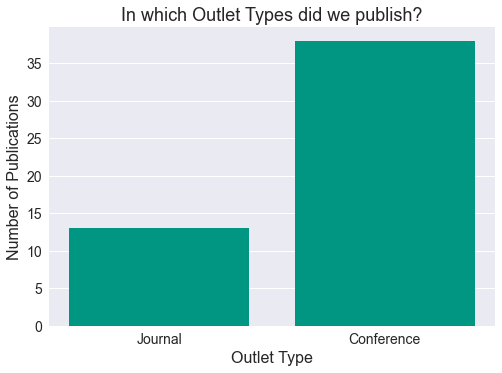

In [88]:
# Get the counts for each outlet type
journal_count = publications_df['outlet_type'].value_counts()['Journal']
conference_count = publications_df['outlet_type'].value_counts()['Conference']

# Create a bar chart
plt.bar(['Journal', 'Conference'], [journal_count, conference_count])
plt.xlabel('Outlet Type')
plt.ylabel('Number of Publications')
plt.title('In which Outlet Types did we publish?')
plt.show()

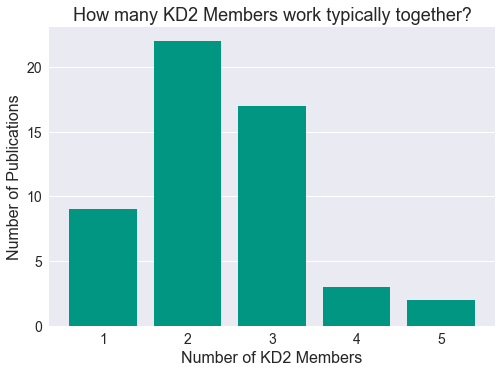

In [89]:
# group by multi_kd2 and count publications
multi_kd2_counts = publications_df.groupby('multi_kd2').size().reset_index(name='count')

# plot bar chart
plt.bar(multi_kd2_counts['multi_kd2'], multi_kd2_counts['count'])
plt.xlabel('Number of KD2 Members')
plt.ylabel('Number of Publications')
plt.title('How many KD2 Members work typically together?')
plt.show()

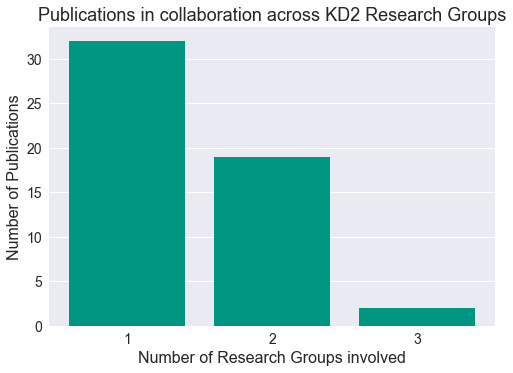

In [90]:
# group by cross_team_kd2 variable and count number of occurrences
counts = publications_df.groupby("cross_team_kd2")["id"].count()

# create bar chart
plt.bar(counts.index, counts.values)

# add axis labels and title
plt.xlabel("Number of Research Groups involved")
plt.ylabel("Number of Publications")
plt.title("Publications in collaboration across KD2 Research Groups")

# Set the x-axis ticks to show only 1, 2, and 3
plt.xticks([1, 2, 3])

# display plot
plt.show()

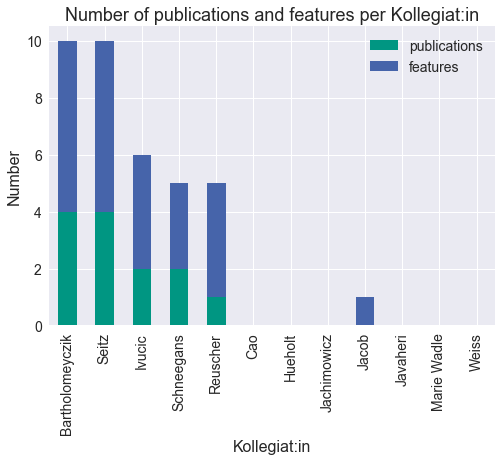

In [91]:
# Filter for members with "Kollegiat:in"
kollegiat_df = people_df[people_df['group'] == 'Kollegiat:in']

# Create a new DataFrame with the total number of publications and features for each member
kollegiat_pubs_feat = kollegiat_df.groupby('last_name').agg({'publications': 'sum', 'features': 'sum'})

# Sort the DataFrame by the total number of publications
kollegiat_pubs_feat = kollegiat_pubs_feat.sort_values('publications', ascending=False)

# Create a stacked bar chart
kollegiat_pubs_feat.plot(kind='bar', stacked=True)

# Set the title and axis labels
plt.title('Number of publications and features per Kollegiat:in')
plt.xlabel('Kollegiat:in')
plt.ylabel('Number')

# Show the plot
plt.show()

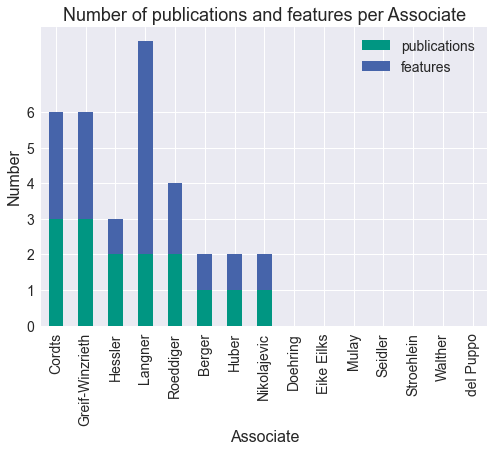

In [92]:
# Filter for members with "Associate"
associate_df = people_df[people_df['group'] == 'Associate']

# Create a new DataFrame with the total number of publications and features for each member
associate_pubs_feat = associate_df.groupby('last_name').agg({'publications': 'sum', 'features': 'sum'})

# Sort the DataFrame by the total number of publications
associate_pubs_feat = associate_pubs_feat.sort_values('publications', ascending=False)

# Create a stacked bar chart
associate_pubs_feat.plot(kind='bar', stacked=True)

# Set the title and axis labels
plt.title('Number of publications and features per Associate')
plt.xlabel('Associate')
plt.ylabel('Number')
plt.yticks(range(0, int(associate_pubs_feat.max().max())+1))

# Show the plot
plt.show()

In [93]:
# read the data from the CSV file
df = pd.read_csv('publications.csv')

# separate the data by semesters
semester1 = df[df['semester'] == 'H2/22']
semester2 = df[df['semester'].isin(['H2/22', 'H1/23'])]

# count the number of publications in each semester and outlet
semester1_counts = semester1.groupby(['outlet_type']).size()
semester2_counts = semester2.groupby(['outlet_type']).size()

print(semester1_counts)
print(semester2_counts)

outlet_type
Conference    17
Journal        7
dtype: int64
outlet_type
Book           1
Conference    33
Journal       10
dtype: int64


### Outlets

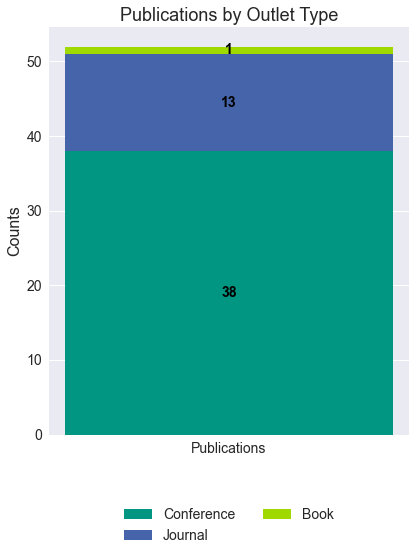

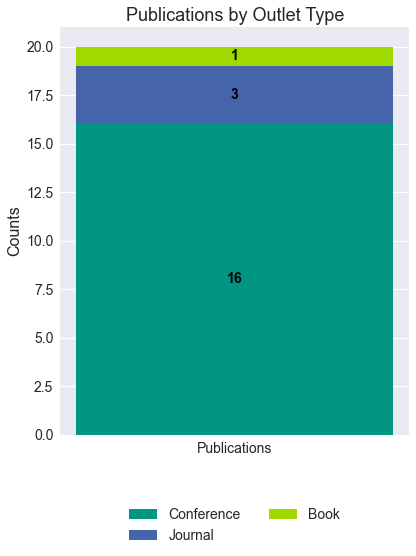

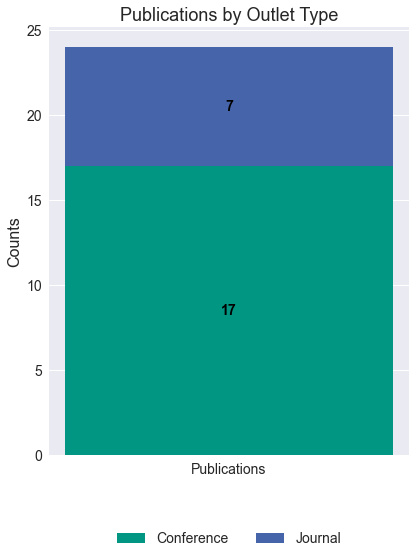

In [94]:
# Count the occurrences of each outlet type
outlet_counts = publications_df['outlet_type'].value_counts()

# Since we're creating a single bar, we'll create dummy data for the x-axis and use the outlet_counts for the y-axis
x_data = ['Publications']
y_data = [outlet_counts.values]

# Colors (can be adjusted)
colors = plt.cm.Paired(range(len(outlet_counts)))

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Since it's a single stacked bar, we need to calculate the bottom for each segment
bottom_data = 0
for idx, (label, value) in enumerate(outlet_counts.items()):
    ax.bar(x_data, value, bottom=bottom_data, label=label)
    # Placing text in the middle of the segment
    ax.text(0, bottom_data + value/2, str(value), ha='center', va='center', color='black', fontweight='bold')
    bottom_data += value

# Styling
ax.set_ylabel('Counts')
ax.set_title('Publications by Outlet Type')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

# Modifying appearance
plt.tight_layout()
plt.show()

# Filter by "H1/23" semester
semester_filter = publications_df['semester'] == 'H1/23'
filtered_df = publications_df[semester_filter]

# Count the occurrences of each outlet type
outlet_counts = filtered_df['outlet_type'].value_counts()

# Since we're creating a single bar, we'll create dummy data for the x-axis and use the outlet_counts for the y-axis
x_data = ['Publications']
y_data = [outlet_counts.values]

# Colors (can be adjusted)
colors = plt.cm.Paired(range(len(outlet_counts)))

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Since it's a single stacked bar, we need to calculate the bottom for each segment
bottom_data = 0
for idx, (label, value) in enumerate(outlet_counts.items()):
    ax.bar(x_data, value, bottom=bottom_data, label=label)
    # Placing text in the middle of the segment
    ax.text(0, bottom_data + value/2, str(value), ha='center', va='center', color='black', fontweight='bold')
    bottom_data += value

# Styling
ax.set_ylabel('Counts')
ax.set_title('Publications by Outlet Type')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

# Modifying appearance
plt.tight_layout()
plt.show()

# Filter by "H2/22" semester
semester_filter = publications_df['semester'] == 'H2/22'
filtered_df = publications_df[semester_filter]

# Count the occurrences of each outlet type
outlet_counts = filtered_df['outlet_type'].value_counts()

# Since we're creating a single bar, we'll create dummy data for the x-axis and use the outlet_counts for the y-axis
x_data = ['Publications']
y_data = [outlet_counts.values]

# Colors (can be adjusted)
colors = plt.cm.Paired(range(len(outlet_counts)))

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Since it's a single stacked bar, we need to calculate the bottom for each segment
bottom_data = 0
for idx, (label, value) in enumerate(outlet_counts.items()):
    ax.bar(x_data, value, bottom=bottom_data, label=label)
    # Placing text in the middle of the segment
    ax.text(0, bottom_data + value/2, str(value), ha='center', va='center', color='black', fontweight='bold')
    bottom_data += value

# Styling
ax.set_ylabel('Counts')
ax.set_title('Publications by Outlet Type')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

# Modifying appearance
plt.tight_layout()
plt.show()

### Members vs Associates

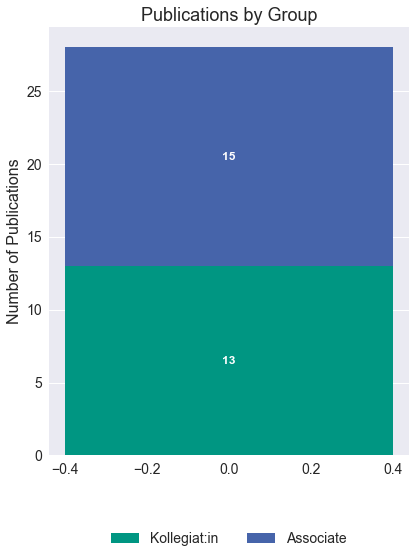

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
people_df = pd.read_csv('people.csv')
publications_df = pd.read_csv('publications.csv')

# Get lists of names for each group
kollegiat_names = people_df[people_df['group'] == 'Kollegiat:in']['name'].tolist()
associate_names = people_df[people_df['group'] == 'Associate']['name'].tolist()

# Count publications for each group
kollegiat_publications = publications_df['main_author_name'].isin(kollegiat_names).sum()
associate_publications = publications_df['main_author_name'].isin(associate_names).sum()

# Data for plotting
counts = [kollegiat_publications, associate_publications]
labels = ['Kollegiat:in', 'Associate']

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Stacked bar plot
bottom = 0
for count, label in zip(counts, labels):
    ax.bar(0, count, bottom=bottom, label=label)
    ax.text(0, bottom + count/2, str(count), ha='center', va='center', color='white', fontweight='bold', fontsize=12)
    bottom += count

# Styling
ax.set_ylabel('Number of Publications')
ax.set_title('Publications by Group')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)

plt.tight_layout()
plt.show()


### Cooperations

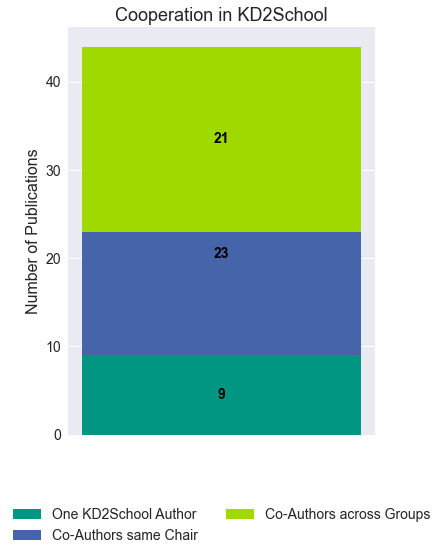

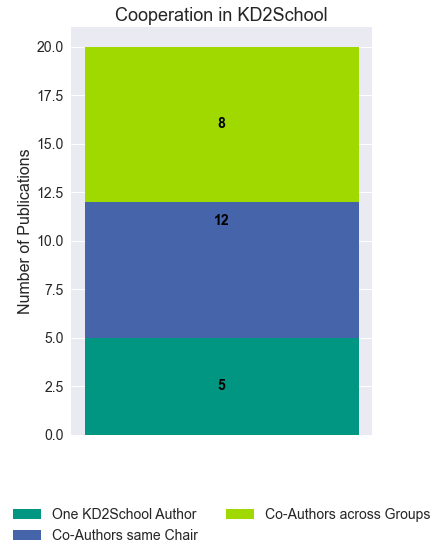

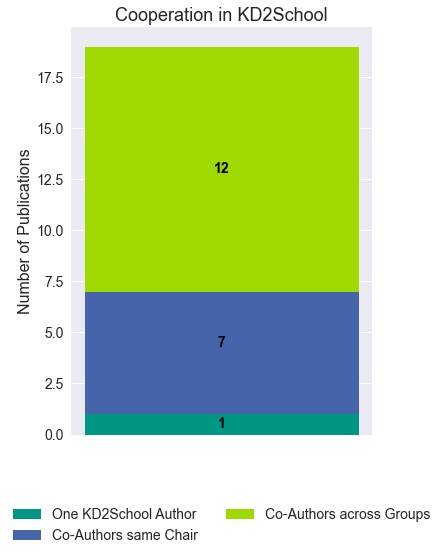

In [96]:
# Define the conditions
conditions = [
    publications_df['multi_kd2'] == 1,
    (publications_df['multi_kd2'] != 1) & (publications_df['cross_team_kd2'] == 1),
    (publications_df['multi_kd2'] != 1) & (publications_df['cross_team_kd2'] != 1)
]

# Category labels
labels = ["One KD2School Author", "Co-Authors same Chair", "Co-Authors across Groups"]

# Calculate counts for each category
counts = [len(publications_df[condition]) for condition in conditions]

# Prepare data for stacking
bottoms = [0] + counts[:-1]

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Stacked bar plot
for i, (count, label, bottom) in enumerate(zip(counts, labels, bottoms)):
    ax.bar(0, count, bottom=bottom, label=label)
    ax.text(0, bottom + count/2, str(count), ha='center', va='center', color='black', fontweight='bold', fontsize=14)

# Styling
ax.set_ylabel('Number of Publications')
ax.set_title('Cooperation in KD2School')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
ax.set_xticks([])

plt.tight_layout()
plt.show()

# Filter by "H2/22" semester
semester_filter = publications_df['semester'] == 'H2/22'
filtered_df = publications_df[semester_filter]

# Define the conditions
conditions = [
    filtered_df['multi_kd2'] == 1,
    (filtered_df['multi_kd2'] != 1) & (filtered_df['cross_team_kd2'] == 1),
    (filtered_df['multi_kd2'] != 1) & (filtered_df['cross_team_kd2'] != 1)
]

# Category labels
labels = ["One KD2School Author", "Co-Authors same Chair", "Co-Authors across Groups"]

# Calculate counts for each category
counts = [len(filtered_df[condition]) for condition in conditions]

# Prepare data for stacking
bottoms = [0] + counts[:-1]

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Stacked bar plot
for i, (count, label, bottom) in enumerate(zip(counts, labels, bottoms)):
    ax.bar(0, count, bottom=bottom, label=label)
    ax.text(0, bottom + count/2, str(count), ha='center', va='center', color='black', fontweight='bold', fontsize=14)

# Styling
ax.set_ylabel('Number of Publications')
ax.set_title('Cooperation in KD2School')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
ax.set_xticks([])

plt.tight_layout()
plt.show()


# Filter by "H1/23" semester
semester_filter = publications_df['semester'] == 'H1/23'
filtered_df = publications_df[semester_filter]

# Define the conditions
conditions = [
    filtered_df['multi_kd2'] == 1,
    (filtered_df['multi_kd2'] != 1) & (filtered_df['cross_team_kd2'] == 1),
    (filtered_df['multi_kd2'] != 1) & (filtered_df['cross_team_kd2'] != 1)
]

# Category labels
labels = ["One KD2School Author", "Co-Authors same Chair", "Co-Authors across Groups"]

# Calculate counts for each category
counts = [len(filtered_df[condition]) for condition in conditions]

# Prepare data for stacking
bottoms = [0] + counts[:-1]

# Plotting
fig, ax = plt.subplots(figsize=(6, 8))

# Stacked bar plot
for i, (count, label, bottom) in enumerate(zip(counts, labels, bottoms)):
    ax.bar(0, count, bottom=bottom, label=label)
    ax.text(0, bottom + count/2, str(count), ha='center', va='center', color='black', fontweight='bold', fontsize=14)

# Styling
ax.set_ylabel('Number of Publications')
ax.set_title('Cooperation in KD2School')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
ax.set_xticks([])

plt.tight_layout()
plt.show()

## HTML Output

In [97]:
# Read the CSV file into a DataFrame
df = pd.read_csv('publications.csv', delimiter = ';')

# Create an empty list to hold the HTML list items
list_items = []

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    # Get the values for the author_names, title, year, and outlet columns
    author_names = row['author_names']
    title = row['title']
    year = row['year']
    outlet = row['outlet']
    
    # Create an HTML list item for the publication
    list_item = f'<li>{author_names} ({year}). "{title}" {outlet} </li>'
    
    # Add the list item to the list of list items
    list_items.append(list_item)

# Join the list of list items into a single string
list_html = '\n'.join(list_items)

# Create the HTML output string
html_output = f'<ul>\n{list_html}\n</ul>'

# Write the HTML output to a file
with open('publications.html', 'w') as f:
    f.write(html_output)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 41, saw 2


# Project Analytics

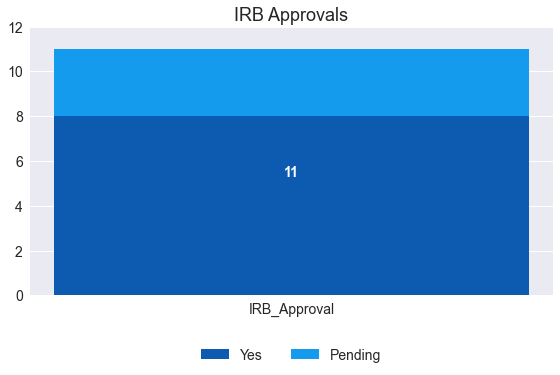

In [98]:
# Initialize counters
yes_count = 0
pending_count = 0

with open(FILE_PATH_PROJECTS, 'r') as csvfile:
    reader = csv.DictReader(csvfile)  # Using DictReader to read the file into a list of dictionaries
    for row in reader:
        if row['IRB_Approval'] == 'Yes':
            yes_count += 1
        elif row['IRB_Approval'] == 'Pending':
            pending_count += 1

# Prepare data for the bar chart
labels = ['IRB_Approval']
yes_data = [yes_count]
pending_data = [pending_count]

# Colors similar to your ggplot example
colors = ["#0C5BB0FF", "#149BEDFF"]

# Plotting
fig, ax = plt.subplots()

# Creating bars
ax.bar(labels, yes_data, color=colors[0], label='Yes')
ax.bar(labels, pending_data, color=colors[1], bottom=yes_data, label='Pending')

# Adding counts in the middle of the bars
total_data = [y + p for y, p in zip(yes_data, pending_data)]
for i, val in enumerate(total_data):
    plt.text(i, val/2, str(val), va='center', ha='center', color='white', fontweight='bold')

# Styling
ax.set_ylabel('Counts')
ax.set_title('IRB Approvals')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
ax.set_ylim(0, max(total_data) + 1)  # +1 to have some space for the top bar

# Removing x and y axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Modifying the appearance
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# Wie viele Hot und Cold Datasets haben wir?

# Wer hat noch keine Angaben gemacht?